# GHP Construction with Duration Matching

In [93]:
import pandas as pd 
import numpy as np 
from sys import path 
path.append('../')
import edhec_risk_kit as erk 

import ipywidgets as widgets
from IPython.display import display

%load_ext autoreload 
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import os 
os.path.abspath(os.curdir)

'/home/tom/Dropbox/projects/coursera_edhec_AdvancedPortfolioConstructionAndAnalysisWithPython/Week 4-Section 1-Dynamic Liability-Driven Investing Strategies: The Emergence Of A New Investment Paradigm For Pension Funds?'

In [61]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns the series of cash flows generated by a bond,
    indexed by the payment/coupon number
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupons = np.repeat(coupon_amt, n_coupons)
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal
    return cash_flows
    
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon date
    and the bond value is computed over time.
    i.e. The index of the discount_rate DataFrame is assumed to be the coupon number
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year,
                                      discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return erk.pv(cash_flows, discount_rate/coupons_per_year)
    
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows 
    """

    discounted_flows = erk.discount(flows.index, discount_rate) * flows 
    weights = discounted_flows / discounted_flows.sum()
    return np.average(flows.index, weights=weights)  # return the weighted average of the times of the cash flows and the weights are computed by the present value of the discounted cash flows


In [62]:
erk.bond_cash_flows(maturity=3, principal=100, coupon_rate=0.03, coupons_per_year=2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [63]:
erk.bond_price(maturity=20, \
               principal=1000, \
                coupon_rate=0.05, \
                coupons_per_year=2, \
                discount_rate=.04)


0    1136.777396
dtype: float64

In [64]:
erk.bond_price(maturity=20, \
               principal=1000, \
                coupon_rate=0.05, \
                coupons_per_year=2, \
                discount_rate=.05)

0    1000.0
dtype: float64

In [65]:
erk.bond_price(maturity=20, \
               principal=1000, \
                coupon_rate=0.05, \
                coupons_per_year=2, \
                discount_rate=.02)

0    1492.520292
dtype: float64

In [66]:
rates = np.linspace(.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [67]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]
prices

[0    1379.748383
 dtype: float64,
 0    1326.762928
 dtype: float64,
 0    1276.163298
 dtype: float64,
 0    1227.833538
 dtype: float64,
 0    1181.663651
 dtype: float64,
 0    1137.549279
 dtype: float64,
 0    1095.3914
 dtype: float64,
 0    1055.096038
 dtype: float64,
 0    1016.573997
 dtype: float64,
 0    979.740605
 dtype: float64,
 0    944.515473
 dtype: float64,
 0    910.822268
 dtype: float64,
 0    878.588497
 dtype: float64,
 0    847.745306
 dtype: float64,
 0    818.227287
 dtype: float64,
 0    789.972298
 dtype: float64,
 0    762.92129
 dtype: float64,
 0    737.018147
 dtype: float64,
 0    712.209532
 dtype: float64,
 0    688.444741
 dtype: float64]

<Axes: title={'center': 'Price of 10yr bond with different interest rates'}>

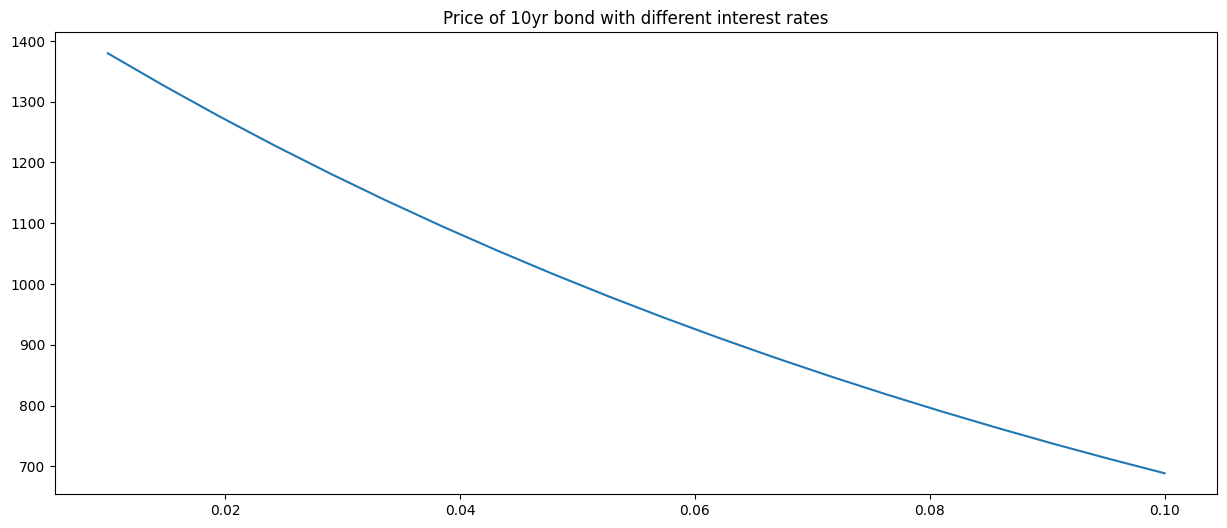

In [68]:
pd.DataFrame(data=prices, index=rates).plot(title='Price of 10yr bond with different interest rates', legend=False, figsize=(15,6))
# as interest rate rises, price of the bond falls

In [69]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [70]:
# want to get the present value of the weight average per cashflow of getting total back 
discounts = erk.discount(cf.index, 0.06/2)
discounts

,0
1,0.970874
2,0.942596
3,0.915142
4,0.888487
5,0.862609
6,0.837484


In [71]:
discounted_cash_flows = discounts[0].values * cf
discounted_cash_flows
# discounts[0].values

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [72]:
weights = discounted_cash_flows/discounted_cash_flows.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [73]:
# Weighted average of the periods 
(cf.index * weights).sum()  # Macaulay duration - how long it takes to recover a bond principal through principal and interest payments 

5.579707187194534

In [74]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), .06/2)

5.579707187194534

# Duration Matching

In [75]:
# 2 $100,000 liabilities 
#   First one due in 10 years 
#   Second one due in 12 years 
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [76]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)

md_10, md_20


(8.190898824083233, 13.544718122145921)

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

```python
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)
```

While we are at it, let's update the funding ratio we developed the last time to support cash flows in the assets:

```python
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return pv(assets, r)/pv(liabilities, r)
```


In [77]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, .04)
w_s

0.48263092069478974

In [91]:
p_short = erk.bond_price(10, 1000, .05, 1, .04)
p_long = erk.bond_price(20, 1000, .05, 1, .04)
a_0 = 130000  # assets (money you have now)

p_flows = pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows, 0.04)
a_0*w_s*short_bond/p_short

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
dtype: float64

In [81]:
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [99]:
cfr = erk.funding_ratio(p_flows, liabilities, .04)

In [101]:
cfr

0    0.0
dtype: float64

<Axes: title={'center': 'Funding Ratios with changes in Interest Rates'}>

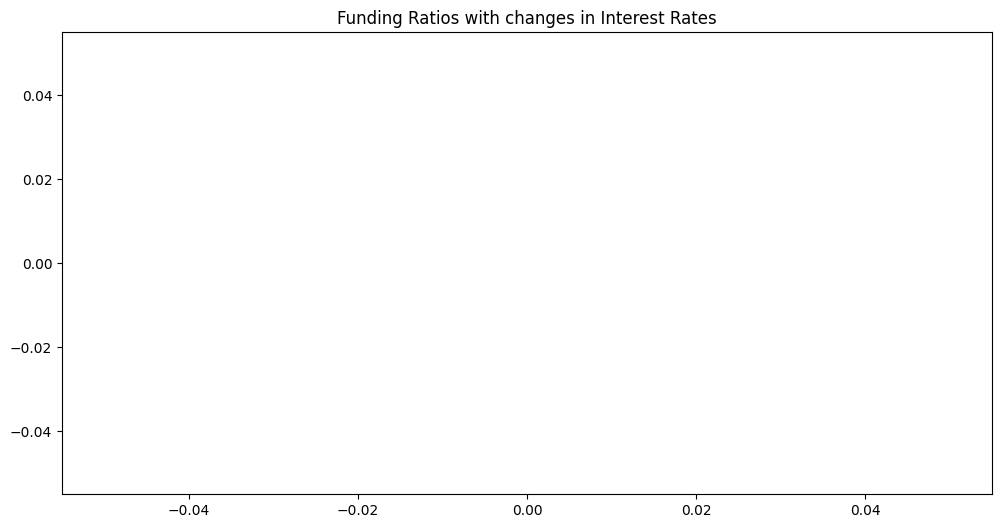

In [104]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short

fr_change = pd.Series({
    'Long Bond': [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    'Short Bond': [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    'Duration Matched Bonds': [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
}, index=rates)

fr_change.plot(title='Funding Ratios with changes in Interest Rates', figsize=(12,6))